# Sentiment Based Product Recommendation System

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from collections import Counter

In [2]:
pd.set_option('display.max_columns', 200)

In [3]:
# NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk import FreqDist, pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, WhitespaceTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RAJKUMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RAJKUMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\RAJKUMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RAJKUMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Modelling libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, classification_report

In [5]:
!pip install imblearn

In [6]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [7]:
df = pd.read_csv('sample30.csv')

In [8]:
df.head(10)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20T00:00:00.000Z,False,False,1,My boyfriend and I bought this to spice things...,Not worth it,NaN,NaN,samantha,Negative
6,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-08T00:00:00.000Z,False,False,1,Bought this earlier today and was excited to c...,Disappointing,NaN,NaN,raeanne,Negative
7,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-21T00:00:00.000Z,False,False,1,I bought this product for my husband and I to ...,Not happy at all,NaN,NaN,kimmie,Negative
8,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-28T00:00:00.000Z,False,False,1,My husband and I bought this for some extra fu...,Very disappointing,NaN,NaN,cassie,Negative
9,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-21T00:00:00.000Z,False,False,1,Got as a surprise for my husband there is noth...,Don't buy,NaN,NaN,moore222,Positive


### Ironically the last entry review says that the customer didn't liked the product ```review_title``` also says "Don't buy" ```reviews_doRecommend``` is also False and ```reviews_rating``` as 1, but ```user_sentiment``` is Positive for this review I dont know how many much more entries are just like that, but this will just lead our work in a wrong direction, so lets correct this.

### Lets convert the ```user_sentiment``` to Negative wherever we find ```reviews_doRecommend``` as False or ```reviews_rating``` < 3.

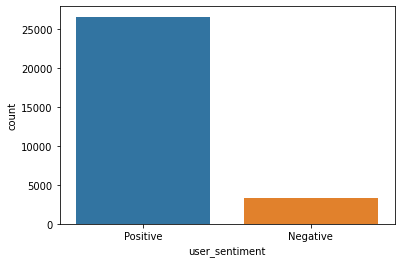

In [9]:
# creating plot to check the ratio of user_sentiment
plt.figure()
sns.countplot(x = 'user_sentiment', data = df)
plt.show()

In [10]:
# Checking for missing values in data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [11]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

##### We can see that ```user_sentiment``` has 1 row NaN, ```review_doRecommend``` has 2570 Nan's, ```review_title``` has 190 NaN's, ```review_username``` also has 63 NaN. now we need username to recommenddation so remove them, so lets do some cleaning.

In [12]:
# dropping rows that have null values
df = df[~df['reviews_doRecommend'].isnull()]
df = df[~df['reviews_username'].isnull()]
df = df[~df['user_sentiment'].isnull()]

In [13]:
df.shape

(27395, 15)

##### lets check again for null values

In [14]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date                0
reviews_didPurchase     11925
reviews_doRecommend         0
reviews_rating              0
reviews_text                0
reviews_title              24
reviews_userCity        25834
reviews_userProvince    27300
reviews_username            0
user_sentiment              0
dtype: int64

##### Now we have removed the null values from ```user_sentiment```, ```review_doRecommend``` and ```review_username```, now for ```review_title``` we'll create and new columns combining both ```review_title``` and ```review_text```

In [15]:
df['review_title_text'] = df['reviews_title'].fillna('') + ' ' + df['reviews_text']

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27395 entries, 3 to 29999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    27395 non-null  object
 1   brand                 27395 non-null  object
 2   categories            27395 non-null  object
 3   manufacturer          27254 non-null  object
 4   name                  27395 non-null  object
 5   reviews_date          27395 non-null  object
 6   reviews_didPurchase   15470 non-null  object
 7   reviews_doRecommend   27395 non-null  object
 8   reviews_rating        27395 non-null  int64 
 9   reviews_text          27395 non-null  object
 10  reviews_title         27371 non-null  object
 11  reviews_userCity      1561 non-null   object
 12  reviews_userProvince  95 non-null     object
 13  reviews_username      27395 non-null  object
 14  user_sentiment        27395 non-null  object
 15  review_title_text     27395 non-null

In [17]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date                0
reviews_didPurchase     11925
reviews_doRecommend         0
reviews_rating              0
reviews_text                0
reviews_title              24
reviews_userCity        25834
reviews_userProvince    27300
reviews_username            0
user_sentiment              0
review_title_text           0
dtype: int64

In [18]:
df.shape

(27395, 16)

### Lets convert the ```user_sentiment``` to Negative wherever we find ```reviews_doRecommend``` as False or ```reviews_rating``` < 3.

In [19]:
def changeSentiment(row):
    if ((not row.reviews_doRecommend) or (row.reviews_rating < 3)):
        return 'Negative'
    return 'Positive'    

In [20]:
df['sentiment_mod'] = df.apply(lambda x : changeSentiment(x), axis = 1)

In [21]:
df['sentiment_mod'].value_counts()

Positive    25746
Negative     1649
Name: sentiment_mod, dtype: int64

In [22]:
df['user_sentiment'].value_counts()

Positive    24459
Negative     2936
Name: user_sentiment, dtype: int64

#### now after doing our analysis on the sentiment we got less Negative reviews that it was there, but yes we've got and right response

In [23]:
df[df.user_sentiment == 'Positive'].head(10)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,review_title_text,sentiment_mod
9,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-21T00:00:00.000Z,False,False,1,Got as a surprise for my husband there is noth...,Don't buy,NaN,NaN,moore222,Positive,Don't buy Got as a surprise for my husband the...,Negative
11,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-05T00:00:00.000Z,False,False,1,Purchased this thinking it would have some sor...,Waste of Money,NaN,NaN,bre234,Positive,Waste of Money Purchased this thinking it woul...,Negative
14,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-09T00:00:00.000Z,False,False,1,First time purchase of this type of product. M...,Disappointed,NaN,NaN,nicole,Positive,Disappointed First time purchase of this type ...,Negative
18,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-01T00:00:00.000Z,True,True,3,I bought this because it had better reviews th...,Pretty nice,NaN,NaN,ll24,Positive,Pretty nice I bought this because it had bette...,Positive
20,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-05-12T00:00:00.000Z,False,True,4,I noticed this product on clearance at a store...,We love it!,NaN,NaN,just faith everyday,Positive,We love it! I noticed this product on clearanc...,Positive
21,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2015-11-04T00:00:00.000Z,False,True,4,I used this product a couple of times since i ...,good times,NaN,NaN,vero,Positive,good times I used this product a couple of tim...,Positive
22,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-07T00:00:00.000Z,False,True,4,Used a few times stays a bit sticky but not to...,Does the job,NaN,NaN,jo276,Positive,Does the job Used a few times stays a bit stic...,Positive
24,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-11-26T00:00:00.000Z,True,True,5,This is a good product. Will give you a great ...,Great sensation,NaN,NaN,jp71,Positive,Great sensation This is a good product. Will g...,Positive
25,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2015-11-05T00:00:00.000Z,False,True,5,I really enjoyed using this product with my hu...,That little extra something..,NaN,NaN,jkell,Positive,That little extra something.. I really enjoyed...,Positive
26,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2015-11-04T00:00:00.000Z,False,True,5,Awesome Product for couples. It is a warm feel...,Great Product!,NaN,NaN,karen,Positive,Great Product! Awesome Product for couples. It...,Positive


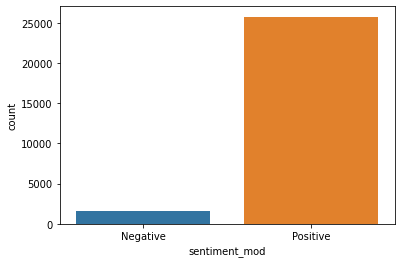

In [24]:
# creating plot to check the ratio of user_sentiment
plt.figure()
sns.countplot(x = 'sentiment_mod', data = df)
plt.show()

In [25]:
def get_wordnet_pos_tags(pos):
    if pos.startswith('J'):
        return wordnet.ADJ
    elif pos.startswith('V'):
        return wordnet.VERB
    elif pos.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

In [26]:

stopwords_list = set(stopwords.words('english')) - {"doesn't", "don't", "can't", "won't", "isn't", "wasn't", "shouldn't", "wouldn't", "couldn't",
                       "no", "not", "never", "nothing", "neither", "none", "nowhere"}

def clean_text(text):
    # lowering text
    text = text.lower()
    
    # tokenize text and remove puncutation
    text = [word.replace('[^\w\s]','') for word in text.split(' ')]
    
    # removing words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # removing stopwords and keeping our negative words for negative reviews
    text = [x for x in text if x not in stopwords_list]
    
    # removing empty tokens
    text = [t for t in text if len(t) > 0]
    
    # getting pos tags
    pos_tags = pos_tag(text)
    
    # Lemmetizing Text
    text = [WordNetLemmatizer().lemmatize(word[0], get_wordnet_pos_tags(word[1])) for word in pos_tags]
    
    # removing word which are only 1 letter
    text = [word for word in text if len(word) > 1]
    
    # concatenating words
    text = ' '.join(text)
    
    return text

In [27]:
time1 = time.time()

df['clean_review'] = df.apply(lambda x : clean_text(x['review_title_text']), axis = 1)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 47.77 seconds


In [28]:
df.head(10)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,review_title_text,sentiment_mod,clean_review
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative,Disappointed I read through the reviews on her...,Negative,disappoint read review look buy one couple lub...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative,Irritation My husband bought this gel for us. ...,Negative,irritation husband buy gel us. gel cause irrit...
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20T00:00:00.000Z,False,False,1,My boyfriend and I bought this to spice things...,Not worth it,NaN,NaN,samantha,Negative,Not worth it My boyfriend and I bought this to...,Negative,not worth boyfriend bought spice thing bedroom...
6,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-08T00:00:00.000Z,False,False,1,Bought this earlier today and was excited to c...,Disappointing,NaN,NaN,raeanne,Negative,Disappointing Bought this earlier today and wa...,Negative,disappoint buy earlier today excite check out....
7,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-21T00:00:00.000Z,False,False,1,I bought this product for my husband and I to ...,Not happy at all,NaN,NaN,kimmie,Negative,Not happy at all I bought this product for my ...,Negative,not happy buy product husband try not impresse...
8,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-28T00:00:00.000Z,False,False,1,My husband and I bought this for some extra fu...,Very disappointing,NaN,NaN,cassie,Negative,Very disappointing My husband and I bought thi...,Negative,disappointing husband buy extra fun. werevboth...
9,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-21T00:00:00.000Z,False,False,1,Got as a surprise for my husband there is noth...,Don't buy,NaN,NaN,moore222,Positive,Don't buy Got as a surprise for my husband the...,Negative,don't buy get surprise husband nothing special...
10,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-08T00:00:00.000Z,False,False,1,tried it with my husband and felt no different...,pretty dissapoitned,NaN,NaN,jds1992,Negative,pretty dissapoitned tried it with my husband a...,Negative,pretty dissapoitned tried husband felt no diff...
11,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-05T00:00:00.000Z,False,False,1,Purchased this thinking it would have some sor...,Waste of Money,NaN,NaN,bre234,Positive,Waste of Money Purchased this thinking it woul...,Negative,waste money purchase think would sort warm eff...
12,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-08T00:00:00.000Z,False,False,1,"Bought this to enhance our time a bit, did abs...",waste of money,NaN,NaN,jds1992,Negative,waste of money Bought this to enhance our time...,Negative,"waste money buy enhance time bit, abslutely no..."


In [29]:
# resetting index
df.reset_index(inplace = True, drop = True)

In [30]:
df

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,review_title_text,sentiment_mod,clean_review
0,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative,Disappointed I read through the reviews on her...,Negative,disappoint read review look buy one couple lub...
1,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative,Irritation My husband bought this gel for us. ...,Negative,irritation husband buy gel us. gel cause irrit...
2,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20T00:00:00.000Z,False,False,1,My boyfriend and I bought this to spice things...,Not worth it,NaN,NaN,samantha,Negative,Not worth it My boyfriend and I bought this to...,Negative,not worth boyfriend bought spice thing bedroom...
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-08T00:00:00.000Z,False,False,1,Bought this earlier today and was excited to c...,Disappointing,NaN,NaN,raeanne,Negative,Disappointing Bought this earlier today and wa...,Negative,disappoint buy earlier today excite check out....
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-21T00:00:00.000Z,False,False,1,I bought this product for my husband and I to ...,Not happy at all,NaN,NaN,kimmie,Negative,Not happy at all I bought this product for my ...,Negative,not happy buy product husband try not impresse...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27390,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-23T00:00:00.000Z,False,True,5,I got this conditioner with Influenster to try...,Softness!!,NaN,NaN,laurasnchz,Positive,Softness!! I got this conditioner with Influen...,Positive,softness!! get conditioner influenster try im ...
27391,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-27T00:00:00.000Z,False,True,5,"I love it , I received this for review purpose...",I love it,NaN,NaN,scarlepadilla,Positive,"I love it I love it , I received this for revi...",Positive,love love receive review purpose influenster l...
27392,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-21T00:00:00.000Z,False,True,5,First of all I love the smell of this product....,Hair is so smooth after use,NaN,NaN,liviasuexo,Positive,Hair is so smooth after use First of all I lov...,Positive,hair smooth use first love smell product. wash...
27393,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-11T00:00:00.000Z,False,True,5,I received this through Influenster and will n...,Perfect for my oily hair!,NaN,NaN,ktreed95,Positive,Perfect for my oily hair! I received this thro...,Positive,perfect oily hair! receive influenster never g...


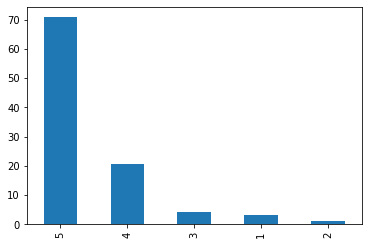

In [31]:
# lets check the % of reviews for the each stars
percent_val2 = 100 * df['reviews_rating'].value_counts()/len(df)
percent_val2.plot.bar()
plt.show()

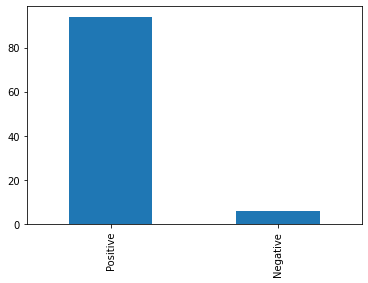

In [32]:
percent_val = 100 * df['sentiment_mod'].value_counts()/len(df)
percent_val.plot.bar()
plt.show()

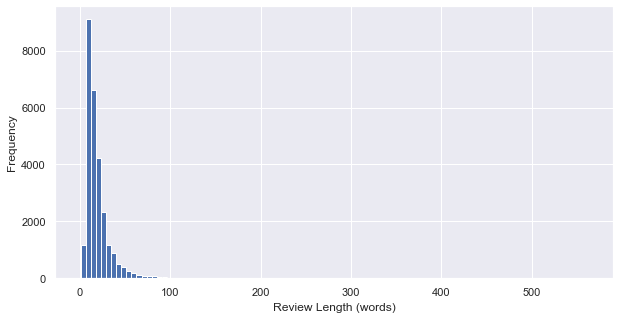

In [33]:
# counting number of words by splitting them by a space
sns.set(font_scale=1)
plt.figure(figsize = (10,5))
words_per_review = df.clean_review.apply(lambda x: len(x.split(' ')))
words_per_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

In [34]:
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 19.192589888665815
Skewness: 5.177820584743163


#### Lets create wordclouds for both positive and negative reviews

In [35]:
positive_reviews = df.loc[df.sentiment_mod=='Positive',['clean_review']]
negative_reviews = df.loc[df.sentiment_mod=='Negative',['clean_review']]

In [36]:
print(positive_reviews)

                                            clean_review
14     pretty nice buy well review jelly, feel like w...
16     love it! noticed product clearance store shop ...
17     good time use product couple time since recive...
18     job use time stays bit sticky not bad, good pr...
19     great sensation good product. give great feeling.
...                                                  ...
27390  softness!! get conditioner influenster try im ...
27391  love love receive review purpose influenster l...
27392  hair smooth use first love smell product. wash...
27393  perfect oily hair! receive influenster never g...
27394  condition healthy receive product complimentar...

[25746 rows x 1 columns]


In [37]:
print(negative_reviews)

                                            clean_review
0      disappoint read review look buy one couple lub...
1      irritation husband buy gel us. gel cause irrit...
2      not worth boyfriend bought spice thing bedroom...
3      disappoint buy earlier today excite check out....
4      not happy buy product husband try not impresse...
...                                                  ...
26733  decent conditioner great price receive along c...
26757  good smell, little heavy really love way condi...
26777  smell great conditioner great although wasn't ...
27223  amazing! get influenster voxbox i'm glad did. ...
27298  love dark brown curly hair love way work hair ...

[1649 rows x 1 columns]


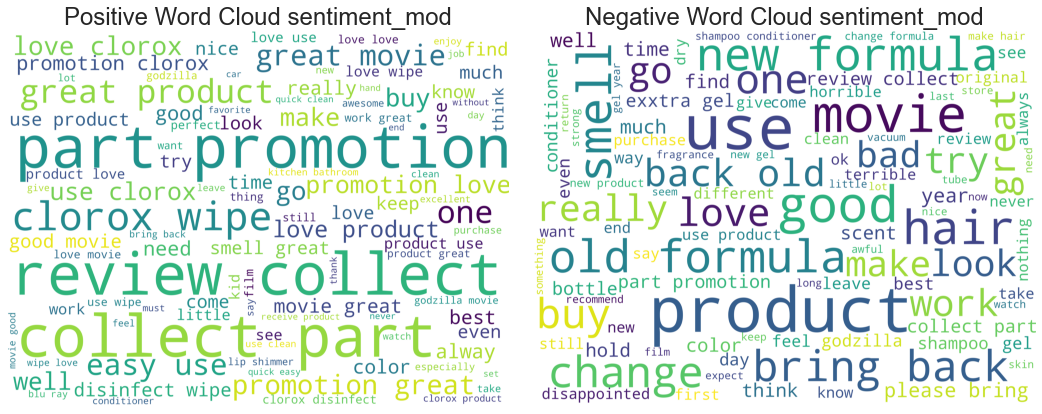

In [38]:
# wordcloud for positive reviews

sns.set(font_scale=2)
plt.figure(figsize = (15,10))

plt.subplot(1, 2, 1)
plt.title('Positive Word Cloud sentiment_mod')

word_cloud_text = ''.join(positive_reviews['clean_review'])
wordcloud = WordCloud(max_font_size = 100, # Maximum font size for the largest word
                      max_words = 100, # The maximum number of words
                      background_color = 'White', # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width = 800, # Width of the canvas
                      height = 600 # Height of the canvas
                     ).generate(word_cloud_text)

plt.imshow(wordcloud, interpolation='bilinear') # to make the displayed image appear more smoothly
plt.axis('off')
plt.tight_layout()

# wordcloud for negative reviews

plt.subplot(1, 2, 2)
plt.title('Negative Word Cloud sentiment_mod')

word_cloud_text = ''.join(negative_reviews['clean_review'])

wordcloud = WordCloud(max_font_size = 100, # Maximum font size for the largest word
                      max_words = 100, # The maximum number of words
                      background_color = 'White', # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width = 800, # Width of the canvas
                      height = 600 # Height of the canvas
                     ).generate(word_cloud_text)

plt.imshow(wordcloud, interpolation='bilinear') # to make the displayed image appear more smoothly
plt.axis("off")
plt.tight_layout()

In [39]:
positive_reviews = df.loc[df.user_sentiment=='Positive',['clean_review']]
negative_reviews = df.loc[df.user_sentiment=='Negative',['clean_review']]

In [40]:
print(positive_reviews)

                                            clean_review
6      don't buy get surprise husband nothing special...
8      waste money purchase think would sort warm eff...
11     disappoint first time purchase type product. m...
14     pretty nice buy well review jelly, feel like w...
16     love it! noticed product clearance store shop ...
...                                                  ...
27390  softness!! get conditioner influenster try im ...
27391  love love receive review purpose influenster l...
27392  hair smooth use first love smell product. wash...
27393  perfect oily hair! receive influenster never g...
27394  condition healthy receive product complimentar...

[24459 rows x 1 columns]


In [41]:
print(negative_reviews)

                                            clean_review
0      disappoint read review look buy one couple lub...
1      irritation husband buy gel us. gel cause irrit...
2      not worth boyfriend bought spice thing bedroom...
3      disappoint buy earlier today excite check out....
4      not happy buy product husband try not impresse...
...                                                  ...
27081  best conditioner ever thin, lifeless, hair. oi...
27254  great prolong color hair! not hair healthy thi...
27257  make hair soft shiny without excess oil! condi...
27261  great conditioner conditioner become staple ha...
27337  good keep combination hair control difficult f...

[2936 rows x 1 columns]


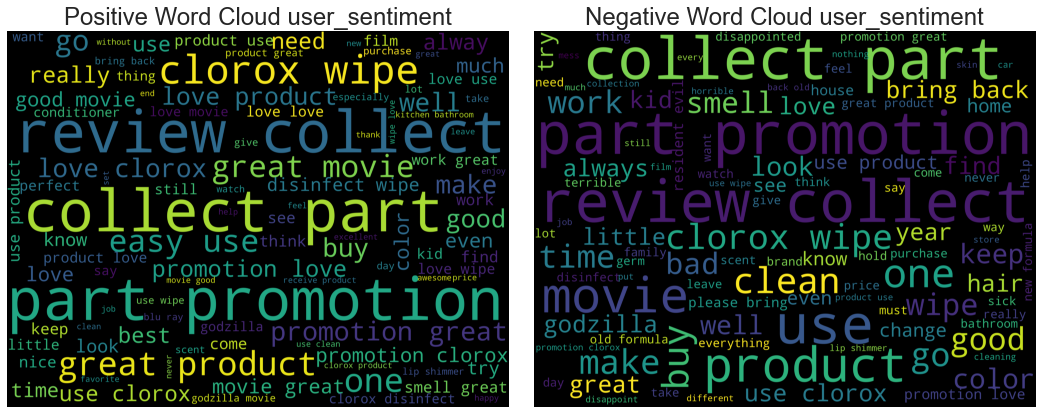

In [42]:
# wordcloud for positive reviews

sns.set(font_scale=2)
plt.figure(figsize = (15,10))

plt.subplot(1, 2, 1)
plt.title('Positive Word Cloud user_sentiment')

word_cloud_text = ''.join(positive_reviews['clean_review'])
wordcloud = WordCloud(max_font_size = 100, # Maximum font size for the largest word
                      max_words = 100, # The maximum number of words
                      background_color = 'rgb(0, 0, 0)', # Background color for the word cloud image
                      mode = 'RGB',
                      scale = 10, # Scaling between computation and drawing
                      width = 800, # Width of the canvas
                      height = 600 # Height of the canvas
                     ).generate(word_cloud_text)

plt.imshow(wordcloud, interpolation='bilinear') # to make the displayed image appear more smoothly
plt.axis('off')
plt.tight_layout()

# wordcloud for negative reviews

plt.subplot(1, 2, 2)
plt.title('Negative Word Cloud user_sentiment')

word_cloud_text = ''.join(negative_reviews['clean_review'])

wordcloud = WordCloud(max_font_size = 100, # Maximum font size for the largest word
                      max_words = 100, # The maximum number of words
                      background_color = 'rgb(0, 0, 0)', # Background color for the word cloud image
                      mode = 'RGB',
                      scale = 10, # Scaling between computation and drawing
                      width = 800, # Width of the canvas
                      height = 600 # Height of the canvas
                     ).generate(word_cloud_text)

plt.imshow(wordcloud, interpolation='bilinear') # to make the displayed image appear more smoothly
plt.axis("off")
plt.tight_layout()

### After changing the sentiment response now we can clearly see the difference between the WordClouds

#### Lets map Positive sentiment to 1 and Negative to 0

In [43]:
df['sentiment_mapped'] = np.where(df['sentiment_mod'] == 'Positive', 1, 0)

In [44]:
df['sentiment_mapped'].value_counts()

1    25746
0     1649
Name: sentiment_mapped, dtype: int64

In [45]:
df.head(10)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,review_title_text,sentiment_mod,clean_review,sentiment_mapped
0,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative,Disappointed I read through the reviews on her...,Negative,disappoint read review look buy one couple lub...,0
1,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative,Irritation My husband bought this gel for us. ...,Negative,irritation husband buy gel us. gel cause irrit...,0
2,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20T00:00:00.000Z,False,False,1,My boyfriend and I bought this to spice things...,Not worth it,NaN,NaN,samantha,Negative,Not worth it My boyfriend and I bought this to...,Negative,not worth boyfriend bought spice thing bedroom...,0
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-08T00:00:00.000Z,False,False,1,Bought this earlier today and was excited to c...,Disappointing,NaN,NaN,raeanne,Negative,Disappointing Bought this earlier today and wa...,Negative,disappoint buy earlier today excite check out....,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-21T00:00:00.000Z,False,False,1,I bought this product for my husband and I to ...,Not happy at all,NaN,NaN,kimmie,Negative,Not happy at all I bought this product for my ...,Negative,not happy buy product husband try not impresse...,0
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-28T00:00:00.000Z,False,False,1,My husband and I bought this for some extra fu...,Very disappointing,NaN,NaN,cassie,Negative,Very disappointing My husband and I bought thi...,Negative,disappointing husband buy extra fun. werevboth...,0
6,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-03-21T00:00:00.000Z,False,False,1,Got as a surprise for my husband there is noth...,Don't buy,NaN,NaN,moore222,Positive,Don't buy Got as a surprise for my husband the...,Negative,don't buy get surprise husband nothing special...,0
7,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-08T00:00:00.000Z,False,False,1,tried it with my husband and felt no different...,pretty dissapoitned,NaN,NaN,jds1992,Negative,pretty dissapoitned tried it with my husband a...,Negative,pretty dissapoitned tried husband felt no diff...,0
8,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-05T00:00:00.000Z,False,False,1,Purchased this thinking it would have some sor...,Waste of Money,NaN,NaN,bre234,Positive,Waste of Money Purchased this thinking it woul...,Negative,waste money purchase think would sort warm eff...,0
9,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-08T00:00:00.000Z,False,False,1,"Bought this to enhance our time a bit, did abs...",waste of money,NaN,NaN,jds1992,Negative,waste of money Bought this to enhance our time...,Negative,"waste money buy enhance time bit, abslutely no...",0


### Creating Tf-Idf features

In [46]:
word_vectorizer = TfidfVectorizer(
    strip_accents = 'unicode',
    analyzer = 'word',
    token_pattern = r'\w{1,}',
    tokenizer= word_tokenize,
    ngram_range = (1, 3),
    stop_words = stopwords_list,
    sublinear_tf = True)

tfidf_data = word_vectorizer.fit_transform(df['clean_review'])

c:\users\rajkumar\.conda\envs\gputest\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'might', 'must', "n't", 'need', 'sha'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [47]:
tfidf_data

<27395x543792 sparse matrix of type '<class 'numpy.float64'>'
	with 1647342 stored elements in Compressed Sparse Row format>

In [48]:
# saving our tfidf vectorizer to pickle file
import pickle

filename = "tfidf_vectorizer.pkl"
with open(filename, 'wb') as file:
    pickle.dump(word_vectorizer, file)

In [49]:
# loading from pickle file
with open(filename, 'rb') as file:
    pickled_tfidf_vectorizer = pickle.load(file)

### Spliting Test and Train Data

In [50]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data, df['sentiment_mapped'], test_size = 0.2, random_state = 3)

In [51]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(y_train_tfidf.shape)
print(y_test_tfidf.shape)

(21916, 543792)
(5479, 543792)
(21916,)
(5479,)


In [52]:
y_train_tfidf.value_counts()

1    20603
0     1313
Name: sentiment_mapped, dtype: int64

In [53]:
y_test_tfidf.value_counts()

1    5143
0     336
Name: sentiment_mapped, dtype: int64

## Logistic Regression

#### As of now we know that we have class imbalances but lets test with Logistic Regression and see how it works

In [54]:
time1 = time.time()

lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train_tfidf.ravel())

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 5.14 seconds


In [55]:
# Predicting Train Data
y_pred_train_lr = lr.predict(X_train_tfidf)

In [56]:
def printReport(y, pred):
    print(classification_report(y, pred))
    print('Accuracy : ', accuracy_score(y, pred))
    print('F1 score: ', f1_score(y, pred))
    print('Recall: ', recall_score(y, pred))
    print('Precision: ', precision_score(y, pred))
    print('')
    print('Confusion Matrix: ')
    print(confusion_matrix(pred, y))

In [57]:
# Model Performance on Train Dataset
print("Logistic Regression accuracy", accuracy_score(y_train_tfidf, y_pred_train_lr))
printReport(y_train_tfidf, y_pred_train_lr)

Logistic Regression accuracy 0.9567895601387114
              precision    recall  f1-score   support

           0       0.99      0.28      0.44      1313
           1       0.96      1.00      0.98     20603

    accuracy                           0.96     21916
   macro avg       0.97      0.64      0.71     21916
weighted avg       0.96      0.96      0.95     21916

Accuracy :  0.9567895601387114
F1 score:  0.9775299561039269
Recall:  0.9998058535164782
Precision:  0.9562250487419924

Confusion Matrix: 
[[  370     4]
 [  943 20599]]


In [58]:
# Prediction Test Data
y_pred_test_lr = lr.predict(X_test_tfidf)

#Model Performance on Test Dataset
print("Logistic Regression accuracy", accuracy_score(y_test_tfidf, y_pred_test_lr))
printReport(y_test_tfidf, y_pred_test_lr)

Logistic Regression accuracy 0.9525460850520168
              precision    recall  f1-score   support

           0       0.99      0.23      0.37       336
           1       0.95      1.00      0.98      5143

    accuracy                           0.95      5479
   macro avg       0.97      0.61      0.67      5479
weighted avg       0.95      0.95      0.94      5479

Accuracy :  0.9525460850520168
F1 score:  0.9753414264036419
Recall:  0.9998055609566401
Precision:  0.9520459174226995

Confusion Matrix: 
[[  77    1]
 [ 259 5142]]


### Now we know that our Negative class is highly less than Positive class, so we need to balance this class imbalance which we'll do with SMOTE 

In [59]:
counter = Counter(y_train_tfidf)
print('Before', counter)

Before Counter({1: 20603, 0: 1313})


In [60]:
sm = SMOTE()

# transform the dataset
X_train_tfidf_sm, y_train_tfidf_sm = sm.fit_resample(X_train_tfidf, y_train_tfidf)

counter = Counter(y_train_tfidf_sm)
print('After', counter)

After Counter({1: 20603, 0: 20603})


In [61]:
time1 = time.time()

lr = LogisticRegression()
lr.fit(X_train_tfidf_sm, y_train_tfidf_sm.ravel())

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 7.98 seconds


In [62]:
# Predicting Train Data with SMOTE
y_pred_train_lr_sm = lr.predict(X_train_tfidf_sm)

In [63]:
# Model Performance on Train Dataset with SMOTE
print("Logistic Regression accuracy", accuracy_score(y_train_tfidf_sm, y_pred_train_lr_sm))
printReport(y_train_tfidf_sm, y_pred_train_lr_sm)

Logistic Regression accuracy 0.9956559724311993
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     20603
           1       1.00      0.99      1.00     20603

    accuracy                           1.00     41206
   macro avg       1.00      1.00      1.00     41206
weighted avg       1.00      1.00      1.00     41206

Accuracy :  0.9956559724311993
F1 score:  0.995642118076689
Recall:  0.9924768237635296
Precision:  0.9988276670574443

Confusion Matrix: 
[[20579   155]
 [   24 20448]]


In [64]:
# Predicting Test Data with SMOTE
y_pred_test_lr_sm = lr.predict(X_test_tfidf)

In [65]:
# Model Performance on Test Dataset with SMOTE
print("Logistic Regression accuracy", accuracy_score(y_test_tfidf, y_pred_test_lr_sm))
printReport(y_test_tfidf, y_pred_test_lr_sm)

Logistic Regression accuracy 0.9622193830991057
              precision    recall  f1-score   support

           0       0.72      0.63      0.67       336
           1       0.98      0.98      0.98      5143

    accuracy                           0.96      5479
   macro avg       0.85      0.81      0.83      5479
weighted avg       0.96      0.96      0.96      5479

Accuracy :  0.9622193830991057
F1 score:  0.979951573849879
Recall:  0.9836671203577678
Precision:  0.9762639907371671

Confusion Matrix: 
[[ 213   84]
 [ 123 5059]]


In [66]:
# Save to file in the current working directory
filename = "logistic_reg_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(lr, file)

In [67]:
# Load from file
with open(filename, 'rb') as file:
    pickled_model_lr = pickle.load(file)

## Random Forest Classifier

#### lets check how Random Forest Classifier works our data

In [68]:
params = {
    'max_features': [10, 20, 30],
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [50, 100, 150, 200],
    'min_samples_split': [100, 150, 200],
    'n_estimators': [100, 200, 300],
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf,
                          param_grid = params,
                          cv = 4,
                          scoring = 'precision',
                          n_jobs = -1,
                          verbose = 1)

In [69]:
# %%time
# time1 = time.time()

# grid_search.fit(X_train_tfidf, y_train_tfidf)

# time_taken = time.time() - time1
# print('Time Taken: {:.2f} seconds'.format(time_taken))

In [70]:
# print('Best Precision Score', grid_search.best_score_)
# print('Best Estimator', grid_search.best_estimator_)
# print('Best Params', grid_search.best_params_)

#### Testing Random Forest Classifier with SMOTE data

In [71]:
%%time
time1 = time.time()

grid_search.fit(X_train_tfidf_sm, y_train_tfidf_sm)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 57.5min finished


Time Taken: 3451.16 seconds
Wall time: 57min 31s


In [72]:
print('Best Precision Score', grid_search.best_score_)
print('Best Estimator', grid_search.best_estimator_)
print('Best Params', grid_search.best_params_)

Best Precision Score 0.8475092360998026
Best Estimator RandomForestClassifier(max_depth=20, max_features=20, min_samples_leaf=100,
                       min_samples_split=200, n_estimators=200)
Best Params {'max_depth': 20, 'max_features': 20, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 200}


#### Without SMOTE

In [74]:
rfc = RandomForestClassifier(
    max_depth=20,
    max_features=20,
    min_samples_leaf=100,
    min_samples_split=200,
    n_estimators = 200,
    bootstrap = True,
    n_jobs = -1,
    verbose = 1)

In [75]:
# fitting training data on tfidf data
time1 = time.time()

rfc.fit(X_train_tfidf, y_train_tfidf)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s


Time Taken: 0.90 seconds


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished


In [76]:
y_pred_train_rfc = rfc.predict(X_train_tfidf)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    2.5s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    2.7s finished


In [77]:
# Model Performance on Train Dataset
print("Random Forest Classifier accuracy", accuracy_score(y_train_tfidf, y_pred_train_rfc))
printReport(y_train_tfidf, y_pred_train_rfc)

Random Forest Classifier accuracy 0.9400894323781712
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1313
           1       0.94      1.00      0.97     20603

    accuracy                           0.94     21916
   macro avg       0.47      0.50      0.48     21916
weighted avg       0.88      0.94      0.91     21916

Accuracy :  0.9400894323781712
F1 score:  0.9691196876690421
Recall:  1.0
Precision:  0.9400894323781712

Confusion Matrix: 
[[    0     0]
 [ 1313 20603]]


c:\users\rajkumar\.conda\envs\gputest\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
y_pred_test_rfc = rfc.predict(X_test_tfidf)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.7s finished


In [79]:
# Model Performance on Test Dataset
print("Random Forest Classifier accuracy", accuracy_score(y_test_tfidf, y_pred_test_rfc))
printReport(y_test_tfidf, y_pred_test_rfc)

Random Forest Classifier accuracy 0.9386749406826063
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       336
           1       0.94      1.00      0.97      5143

    accuracy                           0.94      5479
   macro avg       0.47      0.50      0.48      5479
weighted avg       0.88      0.94      0.91      5479

Accuracy :  0.9386749406826063
F1 score:  0.968367539069855
Recall:  1.0
Precision:  0.9386749406826063

Confusion Matrix: 
[[   0    0]
 [ 336 5143]]


#### WIth SMOTE

In [80]:
# Initializing the best Random Forest Clasifier
rfc = RandomForestClassifier(
    max_depth = 15,
    max_features = 10,
    min_samples_leaf = 50,
    min_samples_split = 100,
    n_estimators = 200,
    bootstrap = True,
    n_jobs = -1,
    verbose = 1)

In [81]:
# fitting training data on smote data
time1 = time.time()

rfc.fit(X_train_tfidf_sm, y_train_tfidf_sm)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s


Time Taken: 1.27 seconds


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.8s finished


In [82]:
y_pred_train_rfc_sm = rfc.predict(X_train_tfidf_sm)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    6.8s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    7.5s finished


In [83]:
# Model Performance on Train Dataset with SMOTE
print("Random Forest Classifier accuracy", accuracy_score(y_train_tfidf_sm, y_pred_train_rfc_sm))
printReport(y_train_tfidf_sm, y_pred_train_rfc_sm)

Random Forest Classifier accuracy 0.600543610153861
              precision    recall  f1-score   support

           0       0.88      0.23      0.37     20603
           1       0.56      0.97      0.71     20603

    accuracy                           0.60     41206
   macro avg       0.72      0.60      0.54     41206
weighted avg       0.72      0.60      0.54     41206

Accuracy :  0.600543610153861
F1 score:  0.7077103384593528
Recall:  0.9671892442848129
Precision:  0.5580073366749742

Confusion Matrix: 
[[ 4819   676]
 [15784 19927]]


In [84]:
y_pred_test_rfc_sm = rfc.predict(X_test_tfidf)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.7s finished


In [85]:
# Model Performance on Test Dataset with SMOTE
print("Random Forest Classifier accuracy", accuracy_score(y_test_tfidf, y_pred_test_rfc_sm))
printReport(y_test_tfidf, y_pred_test_rfc_sm)

Random Forest Classifier accuracy 0.9103851067713087
              precision    recall  f1-score   support

           0       0.16      0.11      0.13       336
           1       0.94      0.96      0.95      5143

    accuracy                           0.91      5479
   macro avg       0.55      0.54      0.54      5479
weighted avg       0.90      0.91      0.90      5479

Accuracy :  0.9103851067713087
F1 score:  0.9527475700125109
Recall:  0.962473264631538
Precision:  0.9432164634146342

Confusion Matrix: 
[[  38  193]
 [ 298 4950]]


## Naive Bayes Classifier

#### Lets test Naive Bayes Classifier for our dataset both with SMOTE or without SMOTE

#### Without SMOTE

In [86]:
nb = MultinomialNB()

In [87]:
time1 = time.time()

nb.fit(X_train_tfidf, y_train_tfidf)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 0.05 seconds


In [88]:
# predicting train data
predict_train_nb = nb.predict(X_train_tfidf)

In [89]:
print("Naive Bayes Classifier accuracy", accuracy_score(y_train_tfidf, predict_train_nb))
printReport(y_train_tfidf, predict_train_nb)

Naive Bayes Classifier accuracy 0.9405913487862748
              precision    recall  f1-score   support

           0       1.00      0.01      0.02      1313
           1       0.94      1.00      0.97     20603

    accuracy                           0.94     21916
   macro avg       0.97      0.50      0.49     21916
weighted avg       0.94      0.94      0.91     21916

Accuracy :  0.9405913487862748
F1 score:  0.9693704714406699
Recall:  1.0
Precision:  0.9405615156356996

Confusion Matrix: 
[[   11     0]
 [ 1302 20603]]


In [90]:
# predicting test data
predict_test_nb = nb.predict(X_test_tfidf)

In [91]:
print("Naive Bayes Classifier accuracy", accuracy_score(y_test_tfidf, predict_test_nb))
printReport(y_test_tfidf, predict_test_nb)

Naive Bayes Classifier accuracy 0.9394050009125753
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       336
           1       0.94      1.00      0.97      5143

    accuracy                           0.94      5479
   macro avg       0.97      0.51      0.50      5479
weighted avg       0.94      0.94      0.91      5479

Accuracy :  0.9394050009125753
F1 score:  0.9687323413072142
Recall:  1.0
Precision:  0.9393607305936073

Confusion Matrix: 
[[   4    0]
 [ 332 5143]]


#### With SMOTE

In [92]:
time1 = time.time()

nb.fit(X_train_tfidf_sm, y_train_tfidf_sm)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 0.06 seconds


In [93]:
# predicting train data
predict_train_nb_sm = nb.predict(X_train_tfidf_sm)

In [94]:
print("Naive Bayes Classifier accuracy", accuracy_score(y_train_tfidf_sm, predict_train_nb_sm))
printReport(y_train_tfidf_sm, predict_train_nb_sm)

Naive Bayes Classifier accuracy 0.9806824248895792
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     20603
           1       1.00      0.96      0.98     20603

    accuracy                           0.98     41206
   macro avg       0.98      0.98      0.98     41206
weighted avg       0.98      0.98      0.98     41206

Accuracy :  0.9806824248895792
F1 score:  0.9803563496372341
Recall:  0.9640829005484638
Precision:  0.9971886138862393

Confusion Matrix: 
[[20547   740]
 [   56 19863]]


In [95]:
# predicting test data
predict_test_nb_sm = nb.predict(X_test_tfidf)

In [96]:
print("Naive Bayes Classifier accuracy", accuracy_score(y_test_tfidf, predict_test_nb_sm))
printReport(y_test_tfidf, predict_test_nb_sm)

Naive Bayes Classifier accuracy 0.909107501368863
              precision    recall  f1-score   support

           0       0.39      0.84      0.53       336
           1       0.99      0.91      0.95      5143

    accuracy                           0.91      5479
   macro avg       0.69      0.88      0.74      5479
weighted avg       0.95      0.91      0.92      5479

Accuracy :  0.909107501368863
F1 score:  0.949666464523954
Recall:  0.9134746257048415
Precision:  0.9888444537992002

Confusion Matrix: 
[[ 283  445]
 [  53 4698]]


In [97]:
# Save to file in the current working directory
filename = "naive_Bayes_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(nb, file)

##### After executing 3 different models we can see that Logistic Regression model has performed better than either two models with or without SMOTE, so from we'll consider the Logistic Regression model as our final model for the prediction.

## Recommendation System

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27395 entries, 0 to 27394
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    27395 non-null  object
 1   brand                 27395 non-null  object
 2   categories            27395 non-null  object
 3   manufacturer          27254 non-null  object
 4   name                  27395 non-null  object
 5   reviews_date          27395 non-null  object
 6   reviews_didPurchase   15470 non-null  object
 7   reviews_doRecommend   27395 non-null  object
 8   reviews_rating        27395 non-null  int64 
 9   reviews_text          27395 non-null  object
 10  reviews_title         27371 non-null  object
 11  reviews_userCity      1561 non-null   object
 12  reviews_userProvince  95 non-null     object
 13  reviews_username      27395 non-null  object
 14  user_sentiment        27395 non-null  object
 15  review_title_text     27395 non-null

In [99]:
df

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,review_title_text,sentiment_mod,clean_review,sentiment_mapped
0,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative,Disappointed I read through the reviews on her...,Negative,disappoint read review look buy one couple lub...,0
1,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative,Irritation My husband bought this gel for us. ...,Negative,irritation husband buy gel us. gel cause irrit...,0
2,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20T00:00:00.000Z,False,False,1,My boyfriend and I bought this to spice things...,Not worth it,NaN,NaN,samantha,Negative,Not worth it My boyfriend and I bought this to...,Negative,not worth boyfriend bought spice thing bedroom...,0
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-08T00:00:00.000Z,False,False,1,Bought this earlier today and was excited to c...,Disappointing,NaN,NaN,raeanne,Negative,Disappointing Bought this earlier today and wa...,Negative,disappoint buy earlier today excite check out....,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-21T00:00:00.000Z,False,False,1,I bought this product for my husband and I to ...,Not happy at all,NaN,NaN,kimmie,Negative,Not happy at all I bought this product for my ...,Negative,not happy buy product husband try not impresse...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27390,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-23T00:00:00.000Z,False,True,5,I got this conditioner with Influenster to try...,Softness!!,NaN,NaN,laurasnchz,Positive,Softness!! I got this conditioner with Influen...,Positive,softness!! get conditioner influenster try im ...,1
27391,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-27T00:00:00.000Z,False,True,5,"I love it , I received this for review purpose...",I love it,NaN,NaN,scarlepadilla,Positive,"I love it I love it , I received this for revi...",Positive,love love receive review purpose influenster l...,1
27392,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-21T00:00:00.000Z,False,True,5,First of all I love the smell of this product....,Hair is so smooth after use,NaN,NaN,liviasuexo,Positive,Hair is so smooth after use First of all I lov...,Positive,hair smooth use first love smell product. wash...,1
27393,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-11T00:00:00.000Z,False,True,5,I received this through Influenster and will n...,Perfect for my oily hair!,NaN,NaN,ktreed95,Positive,Perfect for my oily hair! I received this thro...,Positive,perfect oily hair! receive influenster never g...,1


In [100]:
# doing train and test split
train, test = train_test_split(df, test_size = 0.2, random_state = 3)

In [101]:
print(train.shape)
print(test.shape)

(21916, 19)
(5479, 19)


In [102]:
# creating pivot matrix with username as rows and product id as columns 
df_pivot = train.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).fillna(0)

In [103]:
print(df_pivot.shape)

(19029, 202)


In [104]:
df_pivot

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7fFbilAPnD_xkrmW,AVpf8AoBilAPnD_xkzJ2,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,...,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfErGsLJeJML431yRX,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNfEMLJeJML434uf-,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVp

### Creating dummy dataset

In [105]:
# creating train dummy
dummy_train = train.copy()

In [106]:
# marking not rated products as 1
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x : 0 if x >= 1 else 1)

In [107]:
# creating matrix pivot table of dummy train
dummy_train = dummy_train.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).fillna(1)

In [108]:
dummy_train

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7fFbilAPnD_xkrmW,AVpf8AoBilAPnD_xkzJ2,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,...,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfErGsLJeJML431yRX,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNfEMLJeJML434uf-,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVp

### Cosine Similarity

In [109]:
from sklearn.metrics.pairwise import pairwise_distances

# creating the user similarity matrix using paiwise distance functions
user_correlation = 1 - pairwise_distances(df_pivot, metric = 'cosine')
user_correlation[np.isnan(user_correlation)] = 0

user_correlation

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [110]:
user_correlation.shape

(19029, 19029)

### User - User similarity prediction

In [111]:
user_correlation[user_correlation < 0] = 0
user_correlation

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

Rating predicted by the user for products rated and not rated, is the weighted sum of correlation with the product rating (as present in the rating dataset). 

In [112]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[ 0.        , 15.11422463,  0.        , ...,  0.        ,
         1.57527984,  0.        ],
       [ 3.4701425 , 24.81772875,  0.        , ...,  0.        ,
         3.66576437,  0.        ],
       [ 3.4701425 , 24.81772875,  0.        , ...,  0.        ,
         3.66576437,  0.        ],
       ...,
       [ 0.43033148, 13.15260532,  0.        , ...,  0.        ,
         3.53553391,  0.        ],
       [ 0.        , 15.11422463,  0.        , ...,  0.        ,
         1.57527984,  0.        ],
       [ 0.43033148, 13.15260532,  0.        , ...,  0.        ,
         3.53553391,  0.        ]])

In [113]:
user_predicted_ratings.shape

(19029, 202)

As we're only interested in the products that are not yet rated by the user, so we'll make product rated by user as 0.

In [114]:
user_rating = np.multiply(user_predicted_ratings, dummy_train)
user_rating

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7fFbilAPnD_xkrmW,AVpf8AoBilAPnD_xkzJ2,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,...,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfErGsLJeJML431yRX,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNfEMLJeJML434uf-,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVp

In [115]:
# taking username as input
user_name = str(input('Enter username: '))
print(user_name)

Enter username: 02deuce
02deuce


#### Finding top 5 predictions for the above user

In [116]:
pred_5 = user_rating.loc[user_name].sort_values(ascending = False)[0 : 5]

In [117]:
pred_5

id
AVpfRTh1ilAPnD_xYic2    172.137248
AVpf0eb2LJeJML43EVSt    136.770774
AVpe41TqilAPnD_xQH3d    113.820744
AVpe59io1cnluZ0-ZgDU     69.337793
AVpf3VOfilAPnD_xjpun     67.099996
Name: 02deuce, dtype: float64

#### Mapping product id with product name

In [118]:
mapped = df[['id', 'name']]
mapped = pd.DataFrame.drop_duplicates(mapped)
mapped

,id,name
0,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel
25,AV1d76w7vKc47QAVhCqn,"J.R. Watkins Hand Cream, Lemon Cream"
30,AV1h6gSl-jtxr-f31p40,Ambi Complexion Cleansing Bar
34,AV1h6Gu0glJLPUi8IjA_,"Johnson's Baby Bubble Bath and Wash, 15oz"
47,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream
...,...,...
26337,AVpfUQZjilAPnD_xZfOU,Bedtime Originals Pinkie Musical Mobile
26343,AVpfv4TlilAPnD_xhjNS,Various - Red Hot Blue:Tribute To Cole Porter ...
26345,AVpfVMhR1cnluZ0-ixY8,2017-2018 Brownline174 Duraflex 14-Month Plann...
26346,AVpfVPh3ilAPnD_xZzW9,Mrs. Meyer's Lemon Verbena Surface Scrub


In [119]:
# merging the mapped df with pred to get the name of the recommended products
merged = pd.merge(pred_5, mapped, left_on = 'id', right_on = 'id', how = 'left')
merged

,id,02deuce,name
0,AVpfRTh1ilAPnD_xYic2,172.137248,Planes: Fire Rescue (2 Discs) (includes Digita...
1,AVpf0eb2LJeJML43EVSt,136.770774,The Resident Evil Collection 5 Discs (blu-Ray)
2,AVpe41TqilAPnD_xQH3d,113.820744,Mike Dave Need Wedding Dates (dvd + Digital)
3,AVpe59io1cnluZ0-ZgDU,69.337793,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...
4,AVpf3VOfilAPnD_xjpun,67.099996,Clorox Disinfecting Wipes Value Pack Scented 1...


#### Predicting top 20 recommendation

In [120]:
pred_20 = user_rating.loc[user_name].sort_values(ascending = False)[0 : 20]

In [121]:
# merging the mapped df with pred to get the name of the recommended products
merged = pd.merge(pred_20, mapped, left_on = 'id', right_on = 'id', how = 'left')
merged

,id,02deuce,name
0,AVpfRTh1ilAPnD_xYic2,172.137248,Planes: Fire Rescue (2 Discs) (includes Digita...
1,AVpf0eb2LJeJML43EVSt,136.770774,The Resident Evil Collection 5 Discs (blu-Ray)
2,AVpe41TqilAPnD_xQH3d,113.820744,Mike Dave Need Wedding Dates (dvd + Digital)
3,AVpe59io1cnluZ0-ZgDU,69.337793,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...
4,AVpf3VOfilAPnD_xjpun,67.099996,Clorox Disinfecting Wipes Value Pack Scented 1...
5,AVpf2tw1ilAPnD_xjflC,64.294410,Red (special Edition) (dvdvideo)
6,AVpfJP1C1cnluZ0-e3Xy,35.762234,Clorox Disinfecting Bathroom Cleaner
7,AVpf0thK1cnluZ0-r8vR,33.849675,100:Complete First Season (blu-Ray)
8,AVpe31o71cnluZ0-YrSD,25.010417,Dark Shadows (includes Digital Copy) (ultravio...
9,AV1YGDqsGV-KLJ3adc-O,24.817729,Windex Original Glass Cleaner Refill 67.6oz (2...


### Evaluation - User User similarity recommendation

In [122]:
# finding out common users from test and train dataset
common = test[test.reviews_username.isin(train.reviews_username)]

In [123]:
common

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,review_title_text,sentiment_mod,clean_review,sentiment_mapped
16437,AVpfBrUZilAPnD_xTUly,Coty,"Personal Care,Makeup,Concealer & Foundation,Fo...",Coty brands,"Coty Airspun Face Powder, Translucent Extra Co...",2015-03-19T00:00:00.000Z,True,True,5,Love it. This is by far the best setting powde...,love it,NaN,NaN,shopsalot505,Positive,love it Love it. This is by far the best setti...,Positive,love love it. far best set powder ever used. r...,1
8426,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-01-20T03:23:21.000Z,NaN,True,5,Very easy and convenient. Bad season for sickn...,Wipes,Suffolk,NaN,theresa79,Negative,Wipes Very easy and convenient. Bad season for...,Positive,wipe easy convenient. bad season sicknesses. u...,1
20576,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy,"Personal Care,Hair Care,Shampoo,Featured Brand...",Clear,Clear Scalp & Hair Therapy Total Care Nourishi...,2016-02-18T23:27:12.000Z,NaN,True,4,Cleans and condtions well with no buildup or g...,Good Everyday Shampoo,Tacoma,NaN,k1971,Positive,Good Everyday Shampoo Cleans and condtions wel...,Positive,good everyday shampoo clean condtions well no ...,1
3811,AVpe9W4D1cnluZ0-avf0,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,2010-09-21T00:00:00.000Z,False,True,4,This upright vaccum does all it claims to do. ...,Best vacuum I have had thus far.,NaN,NaN,cleaner mom,Positive,Best vacuum I have had thus far. This upright ...,Positive,best vacuum thus far. upright vaccum claim do....,1
14073,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2012-02-14T00:00:00.000Z,False,True,5,"These are great when in a hurry. Plus, they le...",Convenient and fresh!,NaN,NaN,jillian4,Positive,Convenient and fresh! These are great when in ...,Positive,"convenient fresh! great hurry. plus, leave apa...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17373,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-26T03:04:46.000Z,NaN,True,4,This bathroom cleaner smells greats and takes ...,This Product Does The Best Job When It Comes T...,Birmingham,NaN,coupons2get,Negative,This Product Does The Best Job When It Comes T...,Positive,product best job come clean bathroom bathroom ...,1
16721,AVpfcu821cnluZ0-k8ep,Vaseline,"Personal Care,Skin Care,Lip Care,Beauty,Makeup...",UNILEVER,Vaseline Intensive Care Lip Therapy Cocoa Butter,2015-04-29T02:28:57.000Z,NaN,True,5,Love this product. Its amazing. Made my lips s...,Wonderful,NaN,IL,mimi3,Positive,Wonderful Love this product. Its amazing. Made...,Positive,wonderful love product. amazing. make lip supe...,1
26982,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-27T16:26:29.000Z,NaN,True,4,"Oily hair girls, this is for you. The Clay con...",Works Great In Combination With Shampoo & Mask,Charlotte,NaN,lisbet1388,Positive,Works Great In Combination With Shampoo & Mask...,Positive,work great combination shampoo mask oily hair ...,1
8720,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2014-12-05T12:36:42.000Z,NaN,True,5,The Clorox wipes is the best thing when it com...,Clean Wipes,NaN,NaN,stuffie9663,Positive,Clean Wipes The Clorox wipes is the best thing...,Positive,clean wipe clorox wipe best thing come clean b...,1


In [124]:
# converting into user-product matrix
common_user_matrix = common.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
)

common_user_matrix

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1d76w7vKc47QAVhCqn,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe59io1cnluZ0-ZgDU,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe9W4D1cnluZ0-avf0,AVpe_y-I1cnluZ0-bmvh,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfEqruilAPnD_xUWDr,AVpfGuDrLJeJML432fDz,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfKb8k1cnluZ0-fQdA,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfi79RLJeJML43_Jo0,AVpfjHuw1cnluZ0-mvrX,AVpfl6sF1cnluZ0-nmwC,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yohnie1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [125]:
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,18929,18930,18931,18932,18933,18934,18935,18936,18937,18938,18939,18940,18941,18942,18943,18944,18945,18946,18947,18948,18949,18950,18951,18952,18953,18954,18955,18956,18957,18958,18959,18960,18961,18962,18963,18964,18965,18966,18967,18968,18969,18970,18971,18972,18973,18974,18975,18976,18977,18978,18979,18980,18981,18982,18983,18984,18985,18986,18987,18988,18989,18990,18991,18992,18993,18994,18995,18996,18997,18998,18999,19000,19001,19002,19003,19004,19005,19006,19007,19008,19009,19010,19011,19012,19013,19014,19015,19016,19017,19018,19019,19020,19021,19022,19023,19024,19025,19026,19027,19028
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.468165,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.514496,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.6,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.468165,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.514496,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.6,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.468165,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.514496,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.

In [126]:
user_correlation_df['reviews_username'] = df_pivot.index

user_correlation_df.set_index('reviews_username', inplace = True)
user_correlation_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,18929,18930,18931,18932,18933,18934,18935,18936,18937,18938,18939,18940,18941,18942,18943,18944,18945,18946,18947,18948,18949,18950,18951,18952,18953,18954,18955,18956,18957,18958,18959,18960,18961,18962,18963,18964,18965,18966,18967,18968,18969,18970,18971,18972,18973,18974,18975,18976,18977,18978,18979,18980,18981,18982,18983,18984,18985,18986,18987,18988,18989,18990,18991,18992,18993,18994,18995,18996,18997,18998,18999,19000,19001,19002,19003,19004,19005,19006,19007,19008,19009,19010,19011,19012,19013,19014,19015,19016,19017,19018,19019,19020,19021,19022,19023,19024,19025,19026,19027,19028
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
01impala,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.468165,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.514496,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.6,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.468165,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.514496,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.6,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.468165,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.514496,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [127]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()

user_correlation_df1 = user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df1.shape

(1103, 19029)

In [128]:
user_correlation_df2 = user_correlation_df1.T[user_correlation_df1.T.index.isin(list_name)]

In [129]:
user_correlation_df3 = user_correlation_df2.T

In [130]:
user_correlation_df3.shape

(1103, 1103)

In [131]:
user_correlation_df3

,00sab00,1234567,123charlie,1943,4cloroxl,50cal,85lisa,8ellie24,abby,abcdef,abcdefghij,abcgator,abismomy,actionaction,adam,addmotherhood25,adelynsmom,aep1010,afooey,afwifey2003,aj1135,aj2012,ajackson75,ajune,akhan,alex,alex5514,alexa86,alexis,allie123,amanda01,amandarose,amazing,ambybambi0725,amsey,amy00381,amy1,amyw333,amyx3duh,anas,andie,andrew,angel,angie,angie2,angiesmessykids,anna1202,anne,anthony,aria,arlene,as123,asaump,ash82085,ashley000,ashley06,ashley12,ashsmash,audra,ayterrazas,babas,babs,bams,bananakitty,barb,barbarajean,barra2,batmanny,batts,bbbb,bblack,bbshopper,beabop,bean,becca,beccaruth,becky39,beechetu,bel2006,belle,berstann,bert,beso,bestbuyer,bestbuyfan,bestbuyshopper,besty,bethp,betsy,betty,beverly,bhemp,bigd,bigdog,bigred,bigred1,billybob789,birdman6,bkeys1965,blaine,...,tashafierce,tat2me82,tata87,tausha,taylorsmom12,teacher,techgeek,technobabe415,teerudy,teetee,teresa,terri,terry,tess,tetter74,texasmomma7899,thai,thatguy,the happy cleaner,the1stbambito,thebestthing,themoviemaniac,thequeen,theresa79,thewowfactor,thisjenngirl,thomas,thoppe7,tierrah,tiff,tifflet10,timothy,tina,tina71,tinaj,tinytom,tisha9878,tmoeb,tncq,tobaira,todd,toni,tony,tony1,tooney38,tootsie23,trav,trcvngrn,treese,treesmith,trish,trisha27,truth,ttia,turi,turtle,tw350z,tweetyanne,tycr,typist,ulcunique,unicorn351,valerie1981,vanita80,vccaan,veebee3,veroo,vicki,vickie456,vickie49464,victor,victoria29,victoria354235,viewer,vivi37,vivienne,wally123,wheezie,whome,whythis,wil27,willy,wind,winniepoo2,wiseman378,wolfie,wolverine,wonderwoman,woody,woowoo,worm,xlivayy,yayatex,yeya,yoadrian,yohnie1,zapman,zipper,zippy,zxcsdfd
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.545545,0.419591,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.577350,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.707107,0.0,0.707107,0.360668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.610847,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1234567,0.0,1.000000,0.000000,0.000000,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.707107,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.707107,1.000000,0.000000,0.707107,0.0,0.000000,1.000000,0.000000,0.577350,0.0,0.000000,1.000000,0.000000,0.0,1.000000,1.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.419591,0.000000,1.000000,1.000000,0.500000,0.000000,0.707107,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.707107,0.0,0.780869,1.000000,0.707107,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,1.000000,0.0,0.707107,1.000000,0.000000,0.000000,1.000000,0.0,1.0

In [132]:
user_correlation_df3[user_correlation_df3 < 0] = 0

common_user_pred_rating = np.dot(user_correlation_df3, common_user_matrix.fillna(0))

common_user_pred_rating

array([[0.        , 0.        , 0.        , ..., 0.        , 2.88675135,
        2.43685089],
       [0.        , 0.        , 0.        , ..., 0.        , 5.34858117,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.81901719, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.81901719, 0.        ,
        0.        ],
       [0.8       , 0.        , 0.        , ..., 1.09141031, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 5.34858117,
        0.        ]])

In [133]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x : 1 if x >= 1 else 0)

dummy_test = dummy_test.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).fillna(0)

In [134]:
dummy_test

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1d76w7vKc47QAVhCqn,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe59io1cnluZ0-ZgDU,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe9W4D1cnluZ0-avf0,AVpe_y-I1cnluZ0-bmvh,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfEqruilAPnD_xUWDr,AVpfGuDrLJeJML432fDz,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfKb8k1cnluZ0-fQdA,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfi79RLJeJML43_Jo0,AVpfjHuw1cnluZ0-mvrX,AVpfl6sF1cnluZ0-nmwC,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yohnie1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [135]:
common_user_pred_rating = np.multiply(common_user_pred_rating, dummy_test)
common_user_pred_rating

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1d76w7vKc47QAVhCqn,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe59io1cnluZ0-ZgDU,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe9W4D1cnluZ0-avf0,AVpe_y-I1cnluZ0-bmvh,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfEqruilAPnD_xUWDr,AVpfGuDrLJeJML432fDz,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfKb8k1cnluZ0-fQdA,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfi79RLJeJML43_Jo0,AVpfjHuw1cnluZ0-mvrX,AVpfl6sF1cnluZ0-nmwC,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.169519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1065.63872,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.587800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,51.304618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1065.63872,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

#### Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range

In [136]:
X = common_user_pred_rating.copy()
X = X[X > 0]

In [137]:
scaler = MinMaxScaler(feature_range = (1, 5))
print(scaler.fit(X))

y = (scaler.transform(X))
print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [138]:
common_pivot = common.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
)

In [139]:
common_pivot

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1d76w7vKc47QAVhCqn,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe59io1cnluZ0-ZgDU,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe9W4D1cnluZ0-avf0,AVpe_y-I1cnluZ0-bmvh,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfEqruilAPnD_xUWDr,AVpfGuDrLJeJML432fDz,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfKb8k1cnluZ0-fQdA,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfi79RLJeJML43_Jo0,AVpfjHuw1cnluZ0-mvrX,AVpfl6sF1cnluZ0-nmwC,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yohnie1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [140]:
y

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [141]:
# finding total non NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

1226

In [142]:
# rmse = (sum(sum((common_pivot - y)**2))/total_non_nan)**0.5
# print(rmse)

In [143]:
mse = ((y - common_pivot) ** 2).mean()
mse

id
AV16khLE-jtxr-f38VFn     0.000000
AV1YGDqsGV-KLJ3adc-O     2.503824
AV1YlENIglJLPUi8IHsX     4.000000
AV1YmDL9vKc47QAVgr7_     0.000000
AV1Ymf_rglJLPUi8II2v    16.000000
                          ...    
AVpfrFDZLJeJML43Bmv0    16.000000
AVpfrTyiLJeJML43BrSI     9.000000
AVpfrgjFLJeJML43BvCc    16.000000
AVpfthSailAPnD_xg3ON    16.000000
AVpfv4TlilAPnD_xhjNS    16.000000
Length: 84, dtype: float64

In [144]:
rmse = (sum(mse)/total_non_nan) ** 0.5
rmse

0.7768612226851335

### Item Based Recommendation System

In [145]:
df_pivot = train.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).T

df_pivot

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,1085,10ten,1143mom,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123soccermom,123too,12cass12,12gage,132457,13ld,13ram,1421nikki,143st,148maine,15425shopper,1616,170361eggs,17roses,18612,1863philly,1943,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,19granny,1boomer,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1derpet1,1disappoint,1friendlycat,1gamer,1glenn,1gra,1gussy,1happymom,1healthytot,1hotmama,1izzy1,1jc1,1jodie,1kindword,1movielover2,1nikki31t,1officegal,1okc2thunder3up4,1pleasedclient,1scooby1,1shop,1stgrade,1stlady,1sttimemama,1texasmom,1tomg,1wildbill2l,1witch,2011mom2b,2011pink2011,2015mom,2016,2016home,2062351337,210tundra,21honey,21please,232323,23jen,24hrstoneroses,25happyshopper,262jennifer,2689,2827,28green,295259,2bgreen,2big,2busy4u,2choclabs,2cutekids,2dobies,2ds4es14,2esinapod,2go4savings,...,yoski,youjon,youknowit459,younggrannie62,yourbugginme04,yourmom,youronereviewer,youthfulone,yoyo1245,yozer29,ypryor,yram,yrina03,yshan,ythelastman89,yttric,yucky111,yulkakapulka,yummy,yumyum,yyz2112123,z33pisces,z992,zabdelra,zach,zacharymcneill,zacharysaunt,zacroxs,zaibo,zakkzakk,zamanda,zanarkandruinsx2,zanay,zanzan73,zapman,zara0215,zara07,zarah,zaskar,zaza,zburt5,zchandyman,zebras,zebrastrong,zee74,zeeleader,zelyas,zenanuts,zenmon,zeramm,zero,zetamom,zfem2,zhio,zhynellebb,ziana,zibber23,zibby4,ziggy,zillanator,zimmeyb,zinnian,zipflip,zipp,zipper,zippity,zippy,zitro,zittles,zkondrk,zod10,zodness,zoe1988,zoeellasca,zokhid,zombie,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zout22389,zozo0o,zpalma,zsarah,zsazsa,zt313,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [146]:
# creating item similarity matrix
item_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric = 'cosine')
item_correlation[np.isnan(item_correlation)] = 0

item_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 0.       , ..., 0.       , 0.0055786,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        0.       ],
       [0.       , 0.0055786, 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        1.       ]])

In [147]:
item_correlation.shape

(202, 202)

Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [148]:
item_correlation[item_correlation < 0] = 0
item_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 0.       , ..., 0.       , 0.0055786,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        0.       ],
       [0.       , 0.0055786, 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        1.       ]])

### Prediction - Item Item based

In [149]:
item_pred_rating = np.dot((df_pivot.fillna(0).T), item_correlation)
item_pred_rating

array([[0.        , 0.0544353 , 0.        , ..., 0.        , 0.01133298,
        0.        ],
       [0.02744703, 0.0459576 , 0.        , ..., 0.        , 0.0091937 ,
        0.        ],
       [0.04574505, 0.076596  , 0.        , ..., 0.        , 0.01532283,
        0.        ],
       ...,
       [0.00454725, 0.02286159, 0.        , ..., 0.        , 0.00512133,
        0.        ],
       [0.        , 0.0907255 , 0.        , ..., 0.        , 0.01888831,
        0.        ],
       [0.0036378 , 0.01828927, 0.        , ..., 0.        , 0.00409706,
        0.        ]])

In [150]:
item_pred_rating.shape

(19029, 202)

In [151]:
dummy_train.shape

(19029, 202)

#### Filtering the rating only for the products not rated by user

In [152]:
item_rating = np.multiply(item_pred_rating, dummy_train)
item_rating

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7fFbilAPnD_xkrmW,AVpf8AoBilAPnD_xkzJ2,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBeN6LJeJML430rrn,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,...,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfErGsLJeJML431yRX,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNfEMLJeJML434uf-,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVp

#### Predicting Top 5 recommemdation

In [153]:
# taking userID
user_input = str(input('Enter username: '))
print(user_input)

Enter username: 02deuce
02deuce


In [154]:
pred_5 = item_rating.loc[user_input].sort_values(ascending = False)[0 : 5]
pred_5

id
AVpfRTh1ilAPnD_xYic2    0.169526
AVpf0eb2LJeJML43EVSt    0.161143
AVpe41TqilAPnD_xQH3d    0.159255
AVpe6PCDLJeJML43yFQH    0.112676
AVpe59io1cnluZ0-ZgDU    0.100170
Name: 02deuce, dtype: float64

In [155]:
mapped = df[['id', 'name']]
mapped = pd.DataFrame.drop_duplicates(mapped)
mapped

,id,name
0,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel
25,AV1d76w7vKc47QAVhCqn,"J.R. Watkins Hand Cream, Lemon Cream"
30,AV1h6gSl-jtxr-f31p40,Ambi Complexion Cleansing Bar
34,AV1h6Gu0glJLPUi8IjA_,"Johnson's Baby Bubble Bath and Wash, 15oz"
47,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream
...,...,...
26337,AVpfUQZjilAPnD_xZfOU,Bedtime Originals Pinkie Musical Mobile
26343,AVpfv4TlilAPnD_xhjNS,Various - Red Hot Blue:Tribute To Cole Porter ...
26345,AVpfVMhR1cnluZ0-ixY8,2017-2018 Brownline174 Duraflex 14-Month Plann...
26346,AVpfVPh3ilAPnD_xZzW9,Mrs. Meyer's Lemon Verbena Surface Scrub


In [156]:
# merging the mapped df with pred to get the name of the recommended products
merged = pd.merge(pred_5, mapped, left_on = 'id', right_on = 'id', how = 'left')
merged

,id,02deuce,name
0,AVpfRTh1ilAPnD_xYic2,0.169526,Planes: Fire Rescue (2 Discs) (includes Digita...
1,AVpf0eb2LJeJML43EVSt,0.161143,The Resident Evil Collection 5 Discs (blu-Ray)
2,AVpe41TqilAPnD_xQH3d,0.159255,Mike Dave Need Wedding Dates (dvd + Digital)
3,AVpe6PCDLJeJML43yFQH,0.112676,Wagan Smartac 80watt Inverter With Usb
4,AVpe59io1cnluZ0-ZgDU,0.100170,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...


#### Predicting Top 20 recommemdation

In [157]:
pred_20 = item_rating.loc[user_input].sort_values(ascending = False)[0 : 20]
pred_20

id
AVpfRTh1ilAPnD_xYic2    0.169526
AVpf0eb2LJeJML43EVSt    0.161143
AVpe41TqilAPnD_xQH3d    0.159255
AVpe6PCDLJeJML43yFQH    0.112676
AVpe59io1cnluZ0-ZgDU    0.100170
AVpf0thK1cnluZ0-r8vR    0.100047
AVpfOrD0ilAPnD_xXrRj    0.089899
AVpf2tw1ilAPnD_xjflC    0.087985
AVpfR5m0LJeJML436K3W    0.073590
AVpfD9xTLJeJML431ig2    0.064980
AVpf5olc1cnluZ0-tPrO    0.064136
AVpf4WWN1cnluZ0-s7Wj    0.063568
AVpfgvkJLJeJML43-g1y    0.063568
AV1YGDqsGV-KLJ3adc-O    0.061277
AVpfPnrU1cnluZ0-g9rL    0.060679
AVpfs0tUilAPnD_xgqN2    0.058800
AVpfN6Z71cnluZ0-gZmO    0.056630
AVpe31o71cnluZ0-YrSD    0.055146
AVpfM_ytilAPnD_xXIJb    0.054136
AV1ZSp2uglJLPUi8IQFy    0.052609
Name: 02deuce, dtype: float64

In [158]:
# merging the mapped df with pred to get the name of the recommended products
merged = pd.merge(pred_20, mapped, left_on = 'id', right_on = 'id', how = 'left')
merged

,id,02deuce,name
0,AVpfRTh1ilAPnD_xYic2,0.169526,Planes: Fire Rescue (2 Discs) (includes Digita...
1,AVpf0eb2LJeJML43EVSt,0.161143,The Resident Evil Collection 5 Discs (blu-Ray)
2,AVpe41TqilAPnD_xQH3d,0.159255,Mike Dave Need Wedding Dates (dvd + Digital)
3,AVpe6PCDLJeJML43yFQH,0.112676,Wagan Smartac 80watt Inverter With Usb
4,AVpe59io1cnluZ0-ZgDU,0.100170,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...
5,AVpf0thK1cnluZ0-r8vR,0.100047,100:Complete First Season (blu-Ray)
6,AVpfOrD0ilAPnD_xXrRj,0.089899,Progresso Traditional Chicken Rice With Vegeta...
7,AVpf2tw1ilAPnD_xjflC,0.087985,Red (special Edition) (dvdvideo)
8,AVpfR5m0LJeJML436K3W,0.073590,Jason Aldean - They Don't Know
9,AVpfD9xTLJeJML431ig2,0.064980,There's Something About Mary (dvd)


### Evaluation Item Item based

In [159]:
common = test[test.id.isin(train.id)]
common

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,review_title_text,sentiment_mod,clean_review,sentiment_mapped
9268,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-02-24T00:00:00.000Z,False,True,5,Love Clorox wipes! Use them daily for all mess...,LOVE!,NaN,NaN,smi95,Positive,LOVE! Love Clorox wipes! Use them daily for al...,Positive,love! love clorox wipes! use daily mess around...,1
20371,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2015-08-14T00:00:00.000Z,NaN,True,4,"Good adaption of the book. Good action, intere...",See it,NaN,NaN,spirit,Positive,"See it Good adaption of the book. Good action,...",Positive,"see good adaption book. good action, interest ...",1
22589,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...,2015-12-28T00:00:00.000Z,NaN,True,5,I loved Godzilla as a boy and my son followed ...,Godzilla,NaN,NaN,tonyg7864,Positive,Godzilla I loved Godzilla as a boy and my son ...,Positive,godzilla love godzilla boy son follow footstep...,1
16437,AVpfBrUZilAPnD_xTUly,Coty,"Personal Care,Makeup,Concealer & Foundation,Fo...",Coty brands,"Coty Airspun Face Powder, Translucent Extra Co...",2015-03-19T00:00:00.000Z,True,True,5,Love it. This is by far the best setting powde...,love it,NaN,NaN,shopsalot505,Positive,love it Love it. This is by far the best setti...,Positive,love love it. far best set powder ever used. r...,1
8426,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-01-20T03:23:21.000Z,NaN,True,5,Very easy and convenient. Bad season for sickn...,Wipes,Suffolk,NaN,theresa79,Negative,Wipes Very easy and convenient. Bad season for...,Positive,wipe easy convenient. bad season sicknesses. u...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13641,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-01-02T00:00:00.000Z,False,True,5,Great product. Love the wipes keep them in all...,Love the wipes.,NaN,NaN,joyaa29,Positive,Love the wipes. Great product. Love the wipes ...,Positive,love wipes. great product. love wipe keep vehi...,1
5226,AVpf2tw1ilAPnD_xjflC,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Sh...",Summit Entertainment,Red (special Edition) (dvdvideo),2016-04-04T00:00:00.000Z,NaN,True,4,This action packed spy movie has comedy as wel...,Blast From the Past Spys,NaN,NaN,demonofdoom,Positive,Blast From the Past Spys This action packed sp...,Positive,blast past spys action pack spy movie comedy w...,1
18800,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-02-02T00:00:00.000Z,False,True,5,"I love this product, I have an in home daycare...",Cleans up great,NaN,NaN,daycaremomma,Positive,"Cleans up great I love this product, I have an...",Positive,"clean great love product, home daycare use cle...",1
27080,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-25T21:00:28.000Z,NaN,True,5,I love this conditioner. I got it free from in...,Love This Stuff,Lexington,NaN,lindscharleneh,Positive,Love This Stuff I love this conditioner. I got...,Positive,love stuff love conditioner. get free influens...,1


In [160]:
# creating item matrix
common_item_matrix = common.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).T

In [161]:
common_item_matrix

reviews_username,00dog3,00sab00,0325home,08dallas,09mommy11,1.11E+24,11677j,1234567,123charlie,127726,13dani,13thfaerie,1515,1753,1943,1chynna,1olaygal,1sonny,1stcavdivision,1sungirl,1vgarcia,2013bestbuyer,2014bestbuys,2175046722,2532674594,2athome,2clean4me,2forhokies,2thumbsup,38redsox,3bear,3dcav,3dfan,3littlegirls,4cloroxl,4littleones,4my5goldens,4parman,4theloveofclorox,50cal,5742870423,5mcdaniels,5star414,63lamb,6787249844,70cohoosier,79captm79,85lisa,8ellie24,8kucs,9thdoctor,a leaf on the family tree,a7xmaddlove,aaam,aarhus74,aaronabigail,aaronlab,aaronm,ab45,ab86,ababe,abartine,abby,abby11,abby8992,abc1245,abc3,abcdef,abcdefghij,abcgator,abd1,abismomy,abqdavenm,abuelita,ac228,acarrill93,acehardware,acetolman,acleanerworld,actionaction,actiond,adam,adamsmom,adan,adanas,adapterhdtv,addmotherhood25,adelynsmom,adi0915,admbat,adminpro,aduffy,adventurer,aebt,aebw volunteer,aehr,aelw,aeoldham,aep1010,afooey,...,williamsburg jen,willy,wilma,wilson09,wimbo,wind,wingnthings,winkwink,winniepoo2,wipesgal,wiseman378,withcoppers,withrowtigers01,wizardflame,wizz24,wjefsoccer,wjrr4,wkrp123,wmahoney,wman,wmshopper,wnicole,wojtaszek2014,wolfgang,wolfie,wolverine,wonderwoman,woodque,woodrow54,woody,woody1,woofwoofwoof,woowoo,workfromhomemom,worm,wowwow,write2kjf,wut54,wyatt09,wynnepoohplayer,xander126,xboxdad,xiihong,xlivayy,xmhana,xolisa,xqhinc,xxacw12xx,yamel97,yang,yangko,yankeegirl15,yankees500,yardleysmother,yari34,yary27,yassi,yata32,yayatex,yelley,yes22,yessidoll23,yeya,yoadrian,yoamomovies,yoganicmommy,yogurt,yohnie1,yolita,yosuerte,youknowhowitgoes,youlooksolovely,yunji,yvonne,z12345,zachizz,zachsmom,zak08,zakkwylde29,zapman,zarrahsmommy,zeek09,zegan,zer0zer0agent,zeroonec,zillafan,zina911,zink,zipper,zipperdoo,zippy,zman69,zmikez,zmom,zoey,zoeyny,zoso60,zowie,zulaa118,zxcsdfd
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [162]:
common_item_matrix.shape

(139, 5209)

In [163]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201
0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.003364,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.003397,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.003712,0.000909,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.006758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036869,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.031752,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.009149,0.0,0.0,0.000000,0.0,0.0,0.000000,0.002516,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.02366,0.000000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.117706,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.0,1.000000,0.0,0.0,0.0,0.002886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000529,0.0,0.0,0.020868,0.0,0.000000,0.0,0.0,0.0,0.0,0.030713,0.005242,0.0,0.023873,0.0,0.0,0.018145,0.0,0.0,0.0,0.028811,0.0,0.0,0.016938,0.0,0.0,0.008927,0.026301,0.0,0.0,0.013433,0.0,0.0,0.001068,0.0,0.0,0.0,0.0,0.0,0.008538,0.0,0.0,0.0,0.005862,0.0,0.0,0.002192,0.0,0.014824,0.021401,0.004572,0.0,0.049903,0.009835,0.0,0.012373,0.0,0.008519,0.0,0.005243,0.0,0.005478,0.001419,0.0,0.0,0.0,0.0,0.0,0.008754,0.019604,0.0,0.0,0.0,0.0,0.0,0.004077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013346,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012224,0.0,0.0,0.0,0.0,0.0,0.005773,0.0,0.0,0.0,0.0,0.0,0.0,0.021710,0.012427,0.010013,0.0,0.0,0.0,0.0,0.007707,0.0,0.000287,0.0,0.0,0.015319,0.0,0.0,0.000000,0.0,0.0,0.016324,0.015514,0.0,0.0,0.0,0.0,0.0,0.011285,0.0,0.0,0.0,0.00000,0.000000,0.0,0.00434,0.0,0.0,0.0,0.00803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008687,0.0,0.0,0.0,0.0,0.0,0.0,0.003477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010563,0.008591,0.010624,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.049903,0.0,0.0,0.0,0.005579,0.0
2,0.0,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,

In [164]:
item_correlation_df['id'] = df_pivot.index
item_correlation_df.set_index('id', inplace = True)

item_correlation_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.003364,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.003397,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.003712,0.000909,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.006758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036869,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.031752,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.009149,0.0,0.0,0.000000,0.0,0.0,0.000000,0.002516,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.02366,0.000000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.117706,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.000000,0.0,0.0,0.0,0.002886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000529,0.0,0.0,0.020868,0.0,0.000000,0.0,0.0,0.0,0.0,0.030713,0.005242,0.0,0.023873,0.0,0.0,0.018145,0.0,0.0,0.0,0.028811,0.0,0.0,0.016938,0.0,0.0,0.008927,0.026301,0.0,0.0,0.013433,0.0,0.0,0.001068,0.0,0.0,0.0,0.0,0.0,0.008538,0.0,0.0,0.0,0.005862,0.0,0.0,0.002192,0.0,0.014824,0.021401,0.004572,0.0,0.049903,0.009835,0.0,0.012373,0.0,0.008519,0.0,0.005243,0.0,0.005478,0.001419,0.0,0.0,0.0,0.0,0.0,0.008754,0.019604,0.0,0.0,0.0,0.0,0.0,0.004077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013346,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012224,0.0,0.0,0.0,0.0,0.0,0.005773,0.0,0.0,0.0,0.0,0.0,0.0,0.021710,0.012427,0.010013,0.0,0.0,0.0,0.0,0.007707,0.0,0.000287,0.0,0.0,0.015319,0.0,0.0,0.000000,0.0,0.0,0.016324,0.015514,0.0,0.0,0.0,0.0,0.0,0.011285,0.0,0.0,0.0,0.00000,0.000000,0.0,0.00434,0.0,0.0,0.0,0.00803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008687,0.0,0.0,0.0,0.0,0.0,0.0,0.003477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010563,0.008591,0.010624,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.049903,0.0,0.0,0.0,0.005579,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0

In [165]:
list_name = common.id.tolist()
item_correlation_df.columns = df_pivot.index.tolist()

In [166]:
item_correlation_df1 = item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df2 = item_correlation_df1.T[item_correlation_df1.T.index.isin(list_name)]
item_correlation_df3 = item_correlation_df2.T

In [167]:
item_correlation_df3

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe9W4D1cnluZ0-avf0,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7fFbilAPnD_xkrmW,AVpf99c6LJeJML43Gu3K,AVpf9_3MLJeJML43GvdB,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCuzrilAPnD_xTroT,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfFs_1ilAPnD_xUtRm,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIGFeLJeJML4328YR,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNfEMLJeJML434uf-,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfl6sF1cnluZ0-nmwC,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.003364,0.000000,0.003397,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.003712,0.000909,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.006758,0.0,0.0,0.036869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.031752,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.009149,0.0,0.0,0.000000,0.0,0.0,0.000000,0.002516,0.0,0.0,0.0,0.0,0.000000,0.0,0.02366,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.117706,0.0,0.0,0.0,0.0,0.000000,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.000000,0.0,0.0,0.0,0.002886,0.0,0.0,0.0,0.0,0.0,0.0,0.000529,0.0,0.0,0.0

In [168]:
item_correlation_df3[item_correlation_df3 < 0] = 0

common_item_pred_rating = np.dot(item_correlation_df3, common_item_matrix.fillna(0))
print(common_item_pred_rating.shape)
common_item_pred_rating

(139, 5209)


array([[0.        , 0.00339653, 0.00454725, ..., 0.        , 0.        ,
        0.00454725],
       [0.06775243, 0.02387262, 0.02286159, ..., 0.02621402, 0.07412233,
        0.02286159],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00592926, 0.00512133, ..., 0.        , 0.        ,
        0.00512133],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [169]:
# creating dummy test for evaluation
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

In [170]:
dummy_test = dummy_test.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).T.fillna(0)

common_item_pred_rating = np.multiply(common_item_pred_rating, dummy_test)

In [171]:
common_item_pred_rating

reviews_username,00dog3,00sab00,0325home,08dallas,09mommy11,1.11E+24,11677j,1234567,123charlie,127726,13dani,13thfaerie,1515,1753,1943,1chynna,1olaygal,1sonny,1stcavdivision,1sungirl,1vgarcia,2013bestbuyer,2014bestbuys,2175046722,2532674594,2athome,2clean4me,2forhokies,2thumbsup,38redsox,3bear,3dcav,3dfan,3littlegirls,4cloroxl,4littleones,4my5goldens,4parman,4theloveofclorox,50cal,5742870423,5mcdaniels,5star414,63lamb,6787249844,70cohoosier,79captm79,85lisa,8ellie24,8kucs,9thdoctor,a leaf on the family tree,a7xmaddlove,aaam,aarhus74,aaronabigail,aaronlab,aaronm,ab45,ab86,ababe,abartine,abby,abby11,abby8992,abc1245,abc3,abcdef,abcdefghij,abcgator,abd1,abismomy,abqdavenm,abuelita,ac228,acarrill93,acehardware,acetolman,acleanerworld,actionaction,actiond,adam,adamsmom,adan,adanas,adapterhdtv,addmotherhood25,adelynsmom,adi0915,admbat,adminpro,aduffy,adventurer,aebt,aebw volunteer,aehr,aelw,aeoldham,aep1010,afooey,...,williamsburg jen,willy,wilma,wilson09,wimbo,wind,wingnthings,winkwink,winniepoo2,wipesgal,wiseman378,withcoppers,withrowtigers01,wizardflame,wizz24,wjefsoccer,wjrr4,wkrp123,wmahoney,wman,wmshopper,wnicole,wojtaszek2014,wolfgang,wolfie,wolverine,wonderwoman,woodque,woodrow54,woody,woody1,woofwoofwoof,woowoo,workfromhomemom,worm,wowwow,write2kjf,wut54,wyatt09,wynnepoohplayer,xander126,xboxdad,xiihong,xlivayy,xmhana,xolisa,xqhinc,xxacw12xx,yamel97,yang,yangko,yankeegirl15,yankees500,yardleysmother,yari34,yary27,yassi,yata32,yayatex,yelley,yes22,yessidoll23,yeya,yoadrian,yoamomovies,yoganicmommy,yogurt,yohnie1,yolita,yosuerte,youknowhowitgoes,youlooksolovely,yunji,yvonne,z12345,zachizz,zachsmom,zak08,zakkwylde29,zapman,zarrahsmommy,zeek09,zegan,zer0zer0agent,zeroonec,zillafan,zina911,zink,zipper,zipperdoo,zippy,zman69,zmikez,zmom,zoey,zoeyny,zoso60,zowie,zulaa118,zxcsdfd
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

marking not rated product as 0 for evaluation

In [172]:
common_pivot = common.pivot_table(
    index = 'reviews_username',
    columns = 'id',
    values = 'reviews_rating'
).T

In [173]:
common_pivot

reviews_username,00dog3,00sab00,0325home,08dallas,09mommy11,1.11E+24,11677j,1234567,123charlie,127726,13dani,13thfaerie,1515,1753,1943,1chynna,1olaygal,1sonny,1stcavdivision,1sungirl,1vgarcia,2013bestbuyer,2014bestbuys,2175046722,2532674594,2athome,2clean4me,2forhokies,2thumbsup,38redsox,3bear,3dcav,3dfan,3littlegirls,4cloroxl,4littleones,4my5goldens,4parman,4theloveofclorox,50cal,5742870423,5mcdaniels,5star414,63lamb,6787249844,70cohoosier,79captm79,85lisa,8ellie24,8kucs,9thdoctor,a leaf on the family tree,a7xmaddlove,aaam,aarhus74,aaronabigail,aaronlab,aaronm,ab45,ab86,ababe,abartine,abby,abby11,abby8992,abc1245,abc3,abcdef,abcdefghij,abcgator,abd1,abismomy,abqdavenm,abuelita,ac228,acarrill93,acehardware,acetolman,acleanerworld,actionaction,actiond,adam,adamsmom,adan,adanas,adapterhdtv,addmotherhood25,adelynsmom,adi0915,admbat,adminpro,aduffy,adventurer,aebt,aebw volunteer,aehr,aelw,aeoldham,aep1010,afooey,...,williamsburg jen,willy,wilma,wilson09,wimbo,wind,wingnthings,winkwink,winniepoo2,wipesgal,wiseman378,withcoppers,withrowtigers01,wizardflame,wizz24,wjefsoccer,wjrr4,wkrp123,wmahoney,wman,wmshopper,wnicole,wojtaszek2014,wolfgang,wolfie,wolverine,wonderwoman,woodque,woodrow54,woody,woody1,woofwoofwoof,woowoo,workfromhomemom,worm,wowwow,write2kjf,wut54,wyatt09,wynnepoohplayer,xander126,xboxdad,xiihong,xlivayy,xmhana,xolisa,xqhinc,xxacw12xx,yamel97,yang,yangko,yankeegirl15,yankees500,yardleysmother,yari34,yary27,yassi,yata32,yayatex,yelley,yes22,yessidoll23,yeya,yoadrian,yoamomovies,yoganicmommy,yogurt,yohnie1,yolita,yosuerte,youknowhowitgoes,youlooksolovely,yunji,yvonne,z12345,zachizz,zachsmom,zak08,zakkwylde29,zapman,zarrahsmommy,zeek09,zegan,zer0zer0agent,zeroonec,zillafan,zina911,zink,zipper,zipperdoo,zippy,zman69,zmikez,zmom,zoey,zoeyny,zoso60,zowie,zulaa118,zxcsdfd
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [174]:
X = common_item_pred_rating.copy()
X = X[X > 0]

scaler = MinMaxScaler(feature_range = (1, 5))
scaler.fit(X)
y = (scaler.transform(X))

print(y)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [175]:
# calculating total non nan value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [176]:
total_non_nan

5382

In [177]:
mse = ((y - common_pivot) ** 2).mean()
mse

reviews_username
00dog3        9.0
00sab00       0.0
0325home     16.0
08dallas     16.0
09mommy11    16.0
             ... 
zoeyny       16.0
zoso60       16.0
zowie        16.0
zulaa118     16.0
zxcsdfd      16.0
Length: 5209, dtype: float64

In [178]:
rmse = (sum(mse)/total_non_nan) ** 0.5
rmse

3.5691398883208048

In [179]:
# rmse = (sum(sum((common_pivot - y )**2))/total_non_nan)**0.5
# print(rmse)

#### As we can see that our RMSE with **User - User similartiy based recommendation** was quite less that Item - Item based recommendation so we'll use **User - User similartiy based recommendation** for recommendation.

In [180]:
pred_20 = user_rating.loc[user_name].sort_values(ascending = False)[0 : 20]
merged = pd.merge(pred_20, mapped, left_on = 'id', right_on = 'id', how = 'left')
merged

,id,02deuce,name
0,AVpfRTh1ilAPnD_xYic2,172.137248,Planes: Fire Rescue (2 Discs) (includes Digita...
1,AVpf0eb2LJeJML43EVSt,136.770774,The Resident Evil Collection 5 Discs (blu-Ray)
2,AVpe41TqilAPnD_xQH3d,113.820744,Mike Dave Need Wedding Dates (dvd + Digital)
3,AVpe59io1cnluZ0-ZgDU,69.337793,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...
4,AVpf3VOfilAPnD_xjpun,67.099996,Clorox Disinfecting Wipes Value Pack Scented 1...
5,AVpf2tw1ilAPnD_xjflC,64.294410,Red (special Edition) (dvdvideo)
6,AVpfJP1C1cnluZ0-e3Xy,35.762234,Clorox Disinfecting Bathroom Cleaner
7,AVpf0thK1cnluZ0-r8vR,33.849675,100:Complete First Season (blu-Ray)
8,AVpe31o71cnluZ0-YrSD,25.010417,Dark Shadows (includes Digital Copy) (ultravio...
9,AV1YGDqsGV-KLJ3adc-O,24.817729,Windex Original Glass Cleaner Refill 67.6oz (2...


In [181]:
# saving our pickle file for user rating
user_rating.to_pickle('user_rating.pkl')

In [182]:
# saving our merged df to pickle file
mapped.to_pickle('prod_id_name_mapping.pkl')

In [183]:
# saving our df to pickle file
df.to_pickle('df.pkl')

### Improving recommendations using sentiment

Now we'll user our Logistic Regression for predicting the sentiment of our recommended products

In [184]:
recommendations = pd.merge(pred_20, df[['id', 'clean_review']], left_on = 'id', right_on = 'id', how = 'left')
recommendations

,id,02deuce,clean_review
0,AVpfRTh1ilAPnD_xYic2,172.137248,great movie watch grand child would recommend ...
1,AVpfRTh1ilAPnD_xYic2,172.137248,car cute daughter collect animate movie love c...
2,AVpfRTh1ilAPnD_xYic2,172.137248,poor tier disney movie know disney release gre...
3,AVpfRTh1ilAPnD_xYic2,172.137248,good! can't wait next one. good flick.
4,AVpfRTh1ilAPnD_xYic2,172.137248,ok sequel not good original. disappointed.
...,...,...,...
17152,AVpf7LysilAPnD_xkm9G,11.102150,cusinart always deliver quality durability buy...
17153,AVpf7LysilAPnD_xkm9G,11.102150,great juicer look buy juice extractor one fit ...
17154,AVpf7LysilAPnD_xkm9G,11.102150,great i'm agree pretty good love recommend pre...
17155,AVpf7LysilAPnD_xkm9G,11.102150,great purchase! jack lalaine juicer several ye...


In [185]:
time1 = time.time()

test_tfidf = word_vectorizer.transform(recommendations['clean_review'])
sentiment_pred = lr.predict(test_tfidf)
sentiment_pred_df = pd.DataFrame(sentiment_pred, columns = ['sentiment_predicted'])

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 6.56 seconds


In [186]:
sentiment_pred_df

,sentiment_predicted
0,1
1,0
2,0
3,0
4,0
...,...
17152,1
17153,1
17154,1
17155,1


In [187]:
recommendations = pd.concat([recommendations, sentiment_pred_df], axis = 1)
recommendations

,id,02deuce,clean_review,sentiment_predicted
0,AVpfRTh1ilAPnD_xYic2,172.137248,great movie watch grand child would recommend ...,1
1,AVpfRTh1ilAPnD_xYic2,172.137248,car cute daughter collect animate movie love c...,0
2,AVpfRTh1ilAPnD_xYic2,172.137248,poor tier disney movie know disney release gre...,0
3,AVpfRTh1ilAPnD_xYic2,172.137248,good! can't wait next one. good flick.,0
4,AVpfRTh1ilAPnD_xYic2,172.137248,ok sequel not good original. disappointed.,0
...,...,...,...,...
17152,AVpf7LysilAPnD_xkm9G,11.102150,cusinart always deliver quality durability buy...,1
17153,AVpf7LysilAPnD_xkm9G,11.102150,great juicer look buy juice extractor one fit ...,1
17154,AVpf7LysilAPnD_xkm9G,11.102150,great i'm agree pretty good love recommend pre...,1
17155,AVpf7LysilAPnD_xkm9G,11.102150,great purchase! jack lalaine juicer several ye...,1


##### lets calculate the percent of positive sentiments for the recommended products

In [188]:
groupby = recommendations.groupby('id')
pred_count_df = pd.DataFrame(groupby['sentiment_predicted'].count()).reset_index()
pred_count_df.columns = ['id', 'review_count']
pred_count_df

,id,review_count
0,AV1YGDqsGV-KLJ3adc-O,341
1,AVpe31o71cnluZ0-YrSD,244
2,AVpe41TqilAPnD_xQH3d,757
3,AVpe59io1cnluZ0-ZgDU,668
4,AVpf0eb2LJeJML43EVSt,844
5,AVpf0thK1cnluZ0-r8vR,139
6,AVpf2tw1ilAPnD_xjflC,669
7,AVpf385g1cnluZ0-s0_t,195
8,AVpf3VOfilAPnD_xjpun,8496
9,AVpf4oLxLJeJML43FcxC,308


In [189]:
pred_sum_df = pd.DataFrame(groupby['sentiment_predicted'].sum()).reset_index()
pred_sum_df.columns = ['id', 'pred_pos_review']
pred_sum_df

,id,pred_pos_review
0,AV1YGDqsGV-KLJ3adc-O,273
1,AVpe31o71cnluZ0-YrSD,211
2,AVpe41TqilAPnD_xQH3d,692
3,AVpe59io1cnluZ0-ZgDU,618
4,AVpf0eb2LJeJML43EVSt,824
5,AVpf0thK1cnluZ0-r8vR,138
6,AVpf2tw1ilAPnD_xjflC,656
7,AVpf385g1cnluZ0-s0_t,173
8,AVpf3VOfilAPnD_xjpun,8468
9,AVpf4oLxLJeJML43FcxC,306


In [190]:
new_recom = pd.merge(pred_count_df, pred_sum_df, left_on = 'id', right_on = 'id', how = 'left')
new_recom

,id,review_count,pred_pos_review
0,AV1YGDqsGV-KLJ3adc-O,341,273
1,AVpe31o71cnluZ0-YrSD,244,211
2,AVpe41TqilAPnD_xQH3d,757,692
3,AVpe59io1cnluZ0-ZgDU,668,618
4,AVpf0eb2LJeJML43EVSt,844,824
5,AVpf0thK1cnluZ0-r8vR,139,138
6,AVpf2tw1ilAPnD_xjflC,669,656
7,AVpf385g1cnluZ0-s0_t,195,173
8,AVpf3VOfilAPnD_xjpun,8496,8468
9,AVpf4oLxLJeJML43FcxC,308,306


In [191]:
new_recom['positive_sentiment_rate'] = round(new_recom.pred_pos_review.div(new_recom.review_count).replace(np.inf, 0) * 100, 2)
new_recom = new_recom.sort_values(by = 'positive_sentiment_rate', ascending = False)
new_recom

,id,review_count,pred_pos_review,positive_sentiment_rate
8,AVpf3VOfilAPnD_xjpun,8496,8468,99.67
9,AVpf4oLxLJeJML43FcxC,308,306,99.35
14,AVpfJP1C1cnluZ0-e3Xy,2008,1994,99.30
5,AVpf0thK1cnluZ0-r8vR,139,138,99.28
19,AVpfRTh1ilAPnD_xYic2,1141,1126,98.69
6,AVpf2tw1ilAPnD_xjflC,669,656,98.06
17,AVpfPnrU1cnluZ0-g9rL,186,182,97.85
13,AVpfD9xTLJeJML431ig2,130,127,97.69
4,AVpf0eb2LJeJML43EVSt,844,824,97.63
10,AVpf5olc1cnluZ0-tPrO,172,167,97.09


In [192]:
new_recom = pd.merge(new_recom, mapped, left_on = 'id', right_on = 'id', how = 'left')
new_recom

,id,review_count,pred_pos_review,positive_sentiment_rate,name
0,AVpf3VOfilAPnD_xjpun,8496,8468,99.67,Clorox Disinfecting Wipes Value Pack Scented 1...
1,AVpf4oLxLJeJML43FcxC,308,306,99.35,Avery174 Ready Index Contemporary Table Of Con...
2,AVpfJP1C1cnluZ0-e3Xy,2008,1994,99.30,Clorox Disinfecting Bathroom Cleaner
3,AVpf0thK1cnluZ0-r8vR,139,138,99.28,100:Complete First Season (blu-Ray)
4,AVpfRTh1ilAPnD_xYic2,1141,1126,98.69,Planes: Fire Rescue (2 Discs) (includes Digita...
5,AVpf2tw1ilAPnD_xjflC,669,656,98.06,Red (special Edition) (dvdvideo)
6,AVpfPnrU1cnluZ0-g9rL,186,182,97.85,Stargate (ws) (ultimate Edition) (director's C...
7,AVpfD9xTLJeJML431ig2,130,127,97.69,There's Something About Mary (dvd)
8,AVpf0eb2LJeJML43EVSt,844,824,97.63,The Resident Evil Collection 5 Discs (blu-Ray)
9,AVpf5olc1cnluZ0-tPrO,172,167,97.09,Chester's Cheese Flavored Puffcorn Snacks
